<img title="GitHub Octocat" src='./img/Octocat.jpg' style='height: 60px; padding-right: 15px' alt="Octocat" align="left"> This notebook is part of a GitHub repository: https://github.com/pessini/moby-bikes 
<br>MIT Licensed
<br>Author: Leandro Pessini

# Poisson Distribution

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import numpy as np
import scipy.stats as stats
from patsy import dmatrices

# statsmodels
from statsmodels.stats import diagnostic as diag
import statsmodels.api as sm
from statsmodels.formula.api import glm
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.outliers_influence import variance_inflation_factor

%matplotlib inline
import warnings
warnings.simplefilter('ignore', FutureWarning)

In [2]:
%reload_ext watermark
%watermark -a "Leandro Pessini" -n -u -v -iv -w

Author: Leandro Pessini

Last updated: Sun May 08 2022

Python implementation: CPython
Python version       : 3.9.6
IPython version      : 8.3.0

pandas     : 1.3.0
statsmodels: 0.13.2
seaborn    : 0.11.1
sys        : 3.9.6 | packaged by conda-forge | (default, Jul 11 2021, 03:36:15) 
[Clang 11.1.0 ]
numpy      : 1.21.1
matplotlib : 3.4.2
scipy      : 1.8.0

Watermark: 2.3.0



In [3]:
hourly_data = pd.read_csv('../data/processed/hourly_data.csv')
hourly_rentals = pd.read_csv('../data/processed/hourly_rentals.csv')
hourly_data.head()

,rain,temp,rhum,wdsp,date,hour,day,month,year,holiday,...,season,peak,timesofday,rainfall_intensity,wind_bft,wind_speed_group,temp_r,temp_bin,rhum_bin,count
0,0.0,0.1,98,4,2021-03-01,0,1,3,2021,False,...,Winter,False,Night,no rain,2,Calm / Light Breeze,0,0.0,4.0,0
1,0.0,-1.1,98,3,2021-03-01,1,1,3,2021,False,...,Winter,False,Night,no rain,2,Calm / Light Breeze,-1,0.0,4.0,0
2,0.0,-1.2,98,4,2021-03-01,2,1,3,2021,False,...,Winter,False,Night,no rain,2,Calm / Light Breeze,-1,0.0,4.0,1
3,0.0,-0.9,100,5,2021-03-01,3,1,3,2021,False,...,Winter,False,Night,no rain,2,Calm / Light Breeze,-1,0.0,4.0,0
4,0.0,0.0,100,6,2021-03-01,4,1,3,2021,False,...,Winter,False,Night,no rain,2,Calm / Light Breeze,0,0.0,4.0,0


The Poisson distribution is a probability distribution that is used to model the probability that a certain number of events occur during a fixed time interval.

## Zero-inflated problem

In [4]:
zero_values = len(hourly_data[hourly_data['count'] == 0])
print(f"Zeros (#): {round(zero_values, 2)}")
print(f"Zeros (%): {round((zero_values/hourly_data.shape[0])*100, 2)}%")

Zeros (#): 1794
Zeros (%): 20.48%


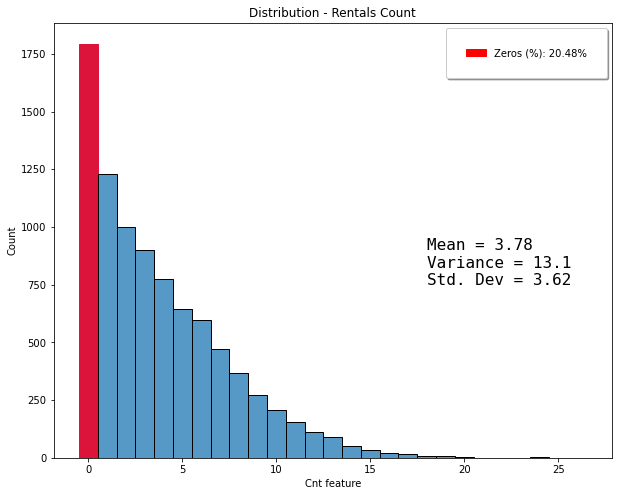

In [5]:
zero_percent = f"Zeros (%): {round((zero_values/hourly_data.shape[0])*100, 2)}%"
stats_df = hourly_data['count'].agg(['mean','var','std'])
label_stats = \
    f"Mean = {round(stats_df['mean'], 2)} \nVariance = {round(stats_df['var'], 2)} \nStd. Dev = {round(stats_df['std'], 2)}"
fig, ax = plt.subplots(figsize=(10, 8))
distri_plot = sns.histplot(data=hourly_data, x='count', ax=ax, stat='count', discrete=True)
ax.set(xlabel='Cnt feature',title="Distribution - Rentals Count")
red_patch = mpatches.Patch(color='red', label=zero_percent)
plt.legend(handles=[red_patch], fancybox=True, framealpha=1, shadow=True, borderpad=2)
heights = [p.get_height() for p in ax.patches]
highest = sorted(heights)[-1]
for p in ax.patches:
    if  p.get_height() >= highest:
        p.set_color('crimson')
distri_plot.annotate(label_stats,xy=(18, 750),fontsize=16,fontfamily='monospace', color='black')
plt.show()

### Distribution across Times of the Day

In [6]:
def labels_zeros(df):
    zero_values = len(df[df['count'] == 0])
    stats_df = df['count'].agg(['mean','var','std'])
    return f"Zeros: {round((zero_values/df.shape[0])*100, 2)}% \n" + \
        f"Mean = {round(stats_df['mean'], 2)} \nVariance = {round(stats_df['var'], 2)} \nStd. Dev = {round(stats_df['std'], 2)} \n" +\
        f"n = {df.shape[0]}"

df_night = hourly_data[hourly_data['timesofday'] == 'Night']
df_morn = hourly_data[hourly_data['timesofday'] == 'Morning']
df_aft = hourly_data[hourly_data['timesofday'] == 'Afternoon']
df_eve = hourly_data[hourly_data['timesofday'] == 'Evening']

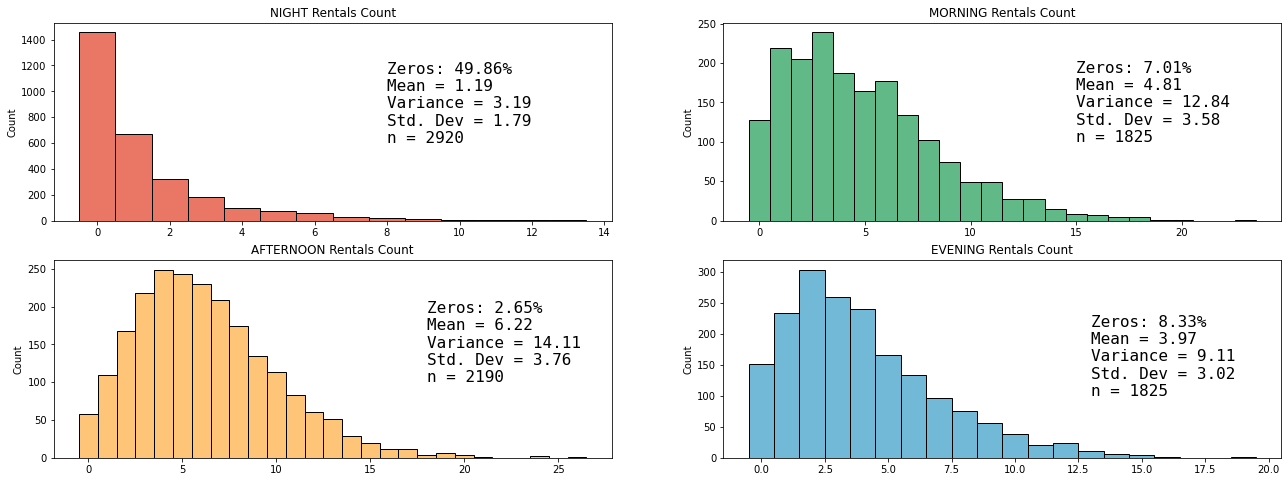

In [7]:
fig = plt.figure(figsize=(22,8))
gs = fig.add_gridspec(2, 2)
ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1])

night_plot = sns.histplot(data=df_night, x='count', ax=ax0, stat='count', discrete=True, color='#e34a33')
morning_plot = sns.histplot(data=df_morn, x='count', ax=ax1, stat='count', discrete=True, color='#2ca25f')
afternoon_plot = sns.histplot(data=df_aft, x='count', ax=ax2, stat='count', discrete=True, color='#feb24c')
evening_plot = sns.histplot(data=df_eve, x='count', ax=ax3, stat='count', discrete=True, color='#43a2ca')

night_plot.annotate(labels_zeros(df_night), xy=(8, 600), fontsize=16, fontfamily='monospace')
label_stats = labels_zeros(df_morn)
morning_plot.annotate(labels_zeros(df_morn), xy=(15, 100), fontsize=16, fontfamily='monospace')
label_stats = labels_zeros(df_aft)
afternoon_plot.annotate(labels_zeros(df_aft), xy=(18, 100), fontsize=16, fontfamily='monospace')
label_stats = labels_zeros(df_eve)
evening_plot.annotate(labels_zeros(df_eve), xy=(13, 100), fontsize=16, fontfamily='monospace')

ax0.set(xlabel='',title="NIGHT Rentals Count")
ax1.set(xlabel='',title="MORNING Rentals Count")
ax2.set(xlabel='',title="AFTERNOON Rentals Count")
ax3.set(xlabel='',title="EVENING Rentals Count")

plt.show()

## Overdispersion

In [ ]:
descriptive_stats = pd.DataFrame({'Statistics': hourly_data['count'].describe(percentiles=[.1, .25, .5, .75, .9])})
descriptive_stats.loc['variance'] = hourly_data['count'].var()
print(f"Mean {round(descriptive_stats.loc['mean'][0], 2)}"+"\n"+f"Variance {round(descriptive_stats.loc['variance'][0], 2)}")

Mean 3.78
Variance 13.1


One assumption of a Poisson distribution is that the `Mean` = `Variance`. As we can see this is not the case ($Var > Mean$).

### Cameron and Trivedi’s (CT) (1990) test

It is based on the assumption that under the Poisson model ${(y-E[y])^2 –E[y]}$ has zero mean:

`H0`: (Poisson Model correct): $Var[yi] = E[yi]$
<br>`HA`: $Var[yi] = E[yi] +α g(E[yi])$

> CT’s rule of thumb: If $Var[yi] / E[yi] > 2$ => **overdispersion**

In [ ]:
print(f'{round(hourly_data["count"].var() / hourly_data["count"].mean(), 2)} => overdispersion found.')

3.47 => overdispersion found.


As a consequence of overdispersed data, we need to fit some other kind of model to the data, accounting for dispersion. Quasi-Poisson and Negative binomial regression are models that deal with over-dispersion.

But if you observe the data set contains an excess of zeroes. If you use a standard Poisson or NB regression model on such data sets, it can fit badly and will generate poor quality predictions, no matter how much you tweak its parameters. 

Fortunately, there is a way to modify a standard counts model such as Poisson or Negative Binomial to account for the presence of the extra zeroes. In fact, there happen to be at least two ways to do this. One technique is known as the Hurdle model and the second technique is known the Zero-Inflated model.

## None rentals (zeroes)

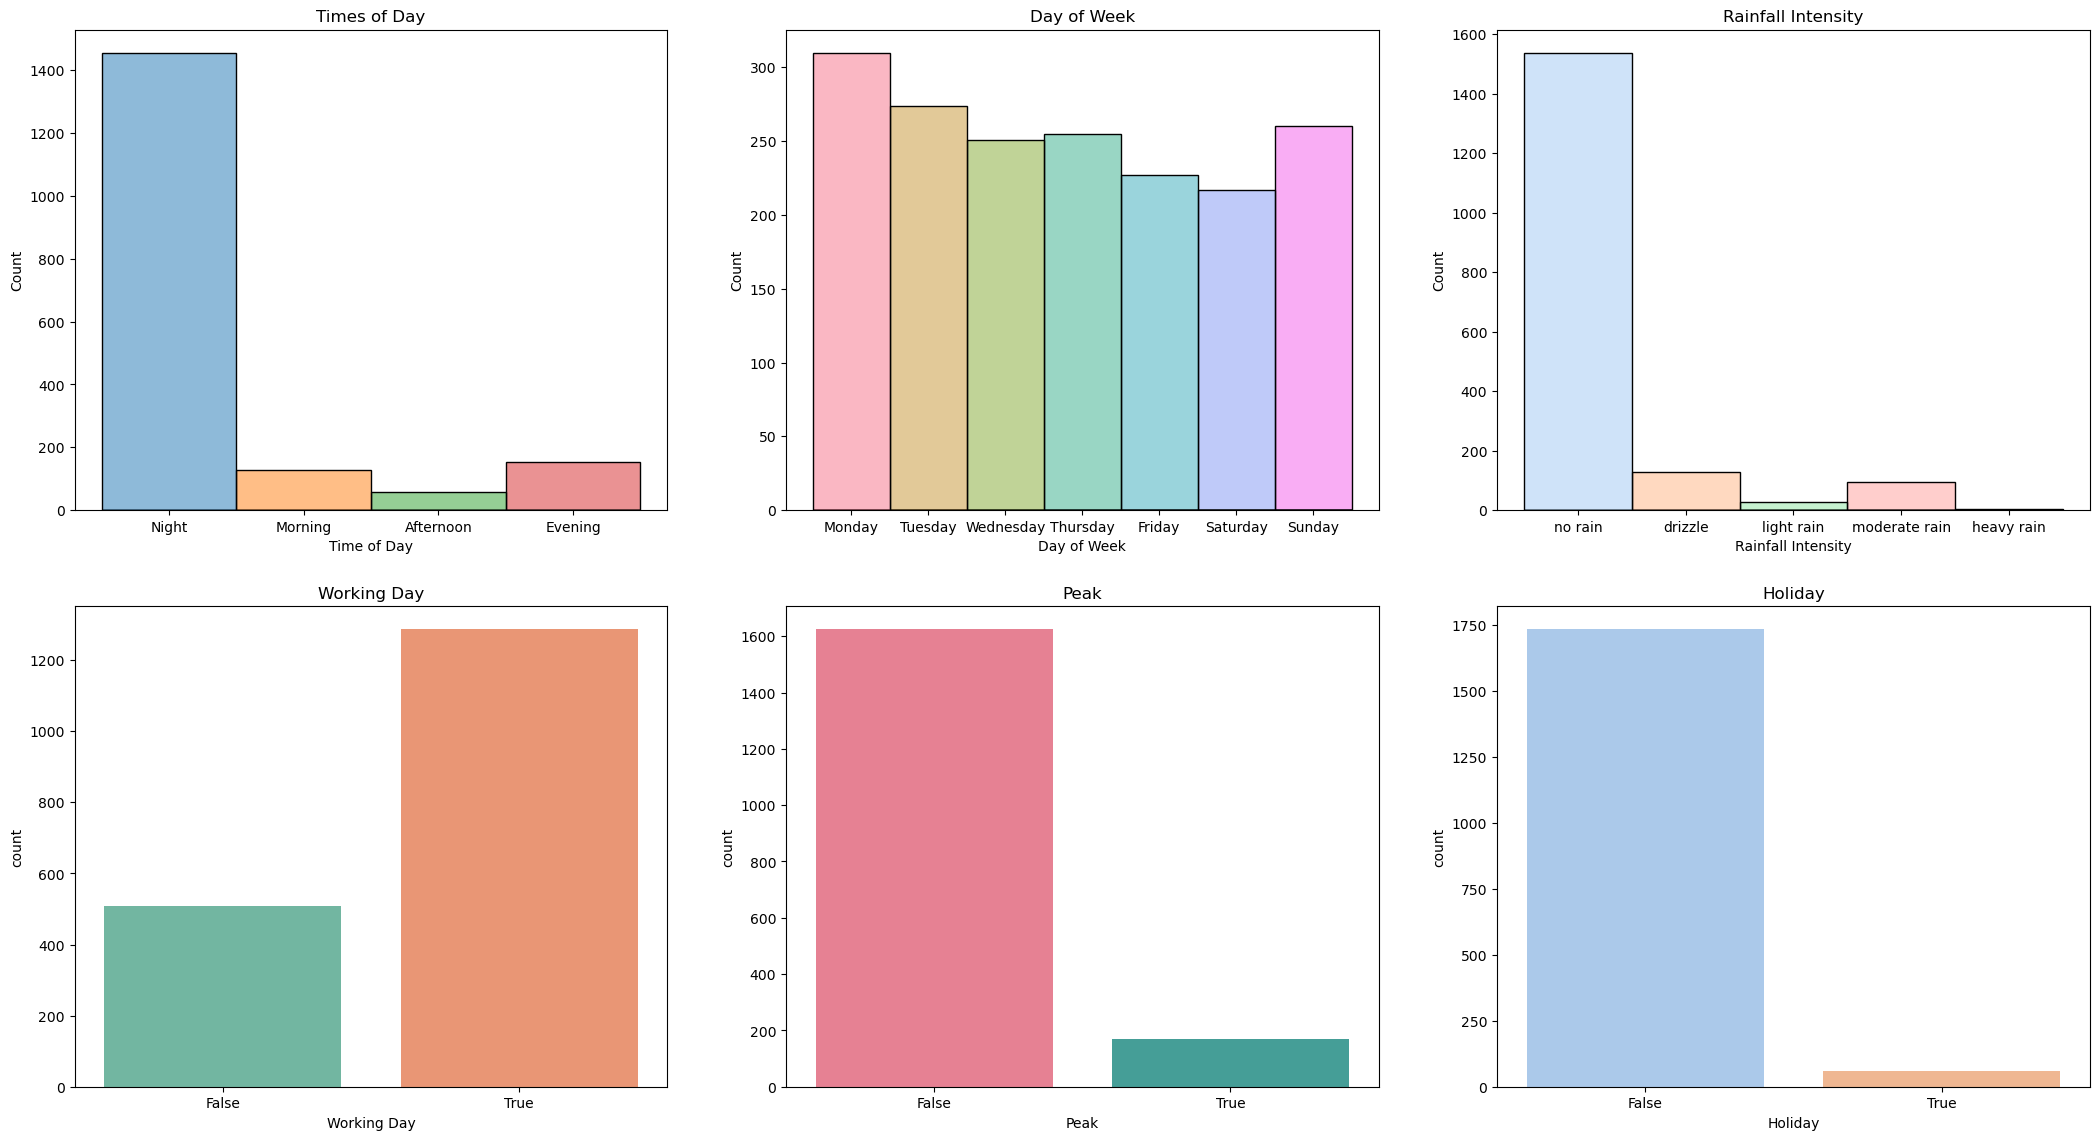

In [8]:
zerocnt_df = hourly_data[hourly_data['count'] == 0].copy()
fig, axes = plt.subplots(nrows=2,ncols=3, figsize=(26,14), dpi=100)

zerocnt_df['timesofday'] = pd.Categorical(zerocnt_df['timesofday'],['Night','Morning','Afternoon','Evening'])
zerocnt_df['rainfall_intensity'] = pd.Categorical(zerocnt_df['rainfall_intensity'],['no rain','drizzle','light rain','moderate rain','heavy rain'])
zerocnt_df['dayofweek'] = pd.Categorical(zerocnt_df['dayofweek'],['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])

sns.histplot(data=zerocnt_df, x='timesofday', stat='count', ax=axes[0][0], hue='timesofday', palette='tab10', legend=False)
sns.histplot(data=zerocnt_df, x='dayofweek', stat='count', ax=axes[0][1], hue='dayofweek', palette='husl', legend=False)
sns.histplot(data=zerocnt_df, x='rainfall_intensity', stat='count', ax=axes[0][2], hue='rainfall_intensity', palette='pastel', legend=False)
axes[0][0].set(xlabel='Time of Day',title="Times of Day")
axes[0][1].set(xlabel='Day of Week',title="Day of Week")
axes[0][2].set(xlabel='Rainfall Intensity',title="Rainfall Intensity")

sns.countplot(data=zerocnt_df, x='working_day', ax=axes[1][0], palette='Set2')
sns.countplot(data=zerocnt_df, x='peak', ax=axes[1][1], palette='husl')
sns.countplot(data=zerocnt_df, x='holiday', ax=axes[1][2], palette='pastel')
axes[1][0].set(xlabel='Working Day',title="Working Day")
axes[1][1].set(xlabel='Peak',title="Peak")
axes[1][2].set(xlabel='Holiday',title="Holiday")

plt.show()

## Zero-inflated (ZI) models

The *hurdle model* or *two-part model* relaxes the assumption that the zeros and the positives come from the same data generating process. A hurdle model has the interpretation that it reflects a two-stage decision-making process. For example, a patient may initiate the first visit to a doctor, but the second and subsequent visits may be determined by a different mechanism. This model works in two steps: 

- In the first step it uses binary classification to discriminate between the zero values and the positive values, 
- and in the second step uses the traditional (poisson or NB) model for positive values.

Zero-inflated negative binomial (ZINB) or Zero-inflated Poisson (ZIP) are models that apply the two-stage process from hurdle models under the hood.

<!-- Zero-inflated Poisson (ZIP)
Hurdle Poisson (HUP)
Negative binomial (NB)
Zero-inflated negative binomial (ZINB)
Hurdle negative binomial (HUNB) -->

In [11]:
print(f'{df_night.shape[0]} => number of NIGHT rentals.')
print(f'{df_morn.shape[0]} => number of MORNING rentals.')
print(f'{df_aft.shape[0]} => number of AFTERNOON rentals.')
print(f'{df_eve.shape[0]} => number of EVENING rentals.')

2920 => number of NIGHT rentals.
1825 => number of MORNING rentals.
2190 => number of AFTERNOON rentals.
1825 => number of EVENING rentals.


In [12]:
expr = \
     """ count ~ temp_r + wdsp + rhum + rain + holiday"""
y_train, X_train = dmatrices(expr, df_aft, return_type = 'dataframe')
nb_training_results = sm.GLM(y_train, X_train, family = sm.families.NegativeBinomial()).fit(maxiter=5000, method='nm', cov_type='HC3')
print(nb_training_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  count   No. Observations:                 2190
Model:                            GLM   Df Residuals:                     2184
Model Family:        NegativeBinomial   Df Model:                            5
Link Function:                    Log   Scale:                          1.0000
Method:                            nm   Log-Likelihood:                -6308.6
Date:                Sun, 08 May 2022   Deviance:                       783.76
Time:                        22:49:23   Pearson chi2:                     630.
No. Iterations:                    56   Pseudo R-squ. (CS):            0.04568
Covariance Type:                  HC3                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           2.6191      0.104     

In [13]:
print(f'AIC: {round(nb_training_results.aic,2)} \nBIC: {round(nb_training_results.bic,2)}')

AIC: 12629.29 
BIC: -16014.82


## Assumptions

**<span style='color: #00cd55'>Assumption 1: The number of events can be counted.</span>**

We assume that the number of “events” that can occur during a given time interval can be counted and can take on the values of 0, 1, 2, 3, … etc.

**<span style='color: #ffea00'>Assumption 2: The occurrence of events are independent.</span>**

We assume that the occurrence of one event does not affect the probability that another event will occur.

**<span style='color: #e60013'>Assumption 3: The average rate at which events occur can be calculated.</span>**

We assume that the average rate at which events occur during a given time interval can be calculated and that it is constant over each sub-interval. No interval can be more likely to have an event than any other interval of the same size.

**<span style='color: #e60013'>Assumption 4: Two events cannot occur at exactly the same instant in time.</span>**

We assume that at each extremely small sub-interval exactly one event occurs or does not occur.

### Considerations

- Count has a fixed range due to limitation on bikes available. (e.g. we cannot have more than 30 rentals if Moby Bikes only has 30 bikes available and to a new rental begins the bike needs to become available. This can violates the `assumption 2` at some level.

- Now we can expected that the rate events occur are constant throughout the day as we saw that usage pattern differs significantly across Night and Afternoon, for example. This violates `assumption 3`.

- On this business case, we can expect bikes being rented at the same time on different stations. This violates `assumption 4`.

<img title="GitHub Mark" src="./img/GitHub-Mark-64px.png" style="height: 32px; padding-right: 15px" alt="GitHub Mark" align="left"> [GitHub repository](https://github.com/pessini/moby-bikes) <br>Author: Leandro Pessini